# 3 - Modelagem

Concluída a fase de exploração de dados, vamos agora modelá-los usando os padrões descobertos.

Nessa fase, buscaremos construir um modelo que, baseado nas variáveis contidas na base de dados de COVID, prediga o resultado de um teste para COVID.

In [1]:
# para carregar a base de dadas limpa
import pickle
from typing import Tuple, List

import numpy as np
import pandas as pd
from scipy import stats as spst
from tqdm import tqdm

# gráficos
import seaborn as sns
from matplotlib import rcParams, rcParamsDefault, pyplot as plt

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams.update(rcParamsDefault)
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

# warnings
import warnings
warnings.filterwarnings("ignore")

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import scripts.plots as splt, scripts.metrics as smetrics
os.chdir(cwd)

## Importação e checagem de integridade

Vamos importar os dados limpos e verificar a integridade dos mesmos.

In [2]:
with open(r'../data/covid_limpo.df', 'rb') as covidfile:
    pickler = pickle.Unpickler(file = covidfile)
    covid_full = pickler.load()

In [3]:
covid_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495062 entries, 0 to 499691
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  495062 non-null  category
 1   patient_type         495062 non-null  category
 2   pneumonia            495062 non-null  category
 3   age                  495062 non-null  int8    
 4   pregnancy            495062 non-null  category
 5   diabetes             495062 non-null  category
 6   copd                 495062 non-null  category
 7   asthma               495062 non-null  category
 8   inmsupr              495062 non-null  category
 9   hypertension         495062 non-null  category
 10  other_disease        495062 non-null  category
 11  cardiovascular       495062 non-null  category
 12  obesity              495062 non-null  category
 13  renal_chronic        495062 non-null  category
 14  tobacco              495062 non-null  category
 15  

In [4]:
covid_full.head()

,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,,
0,0,1,0,27,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,24,0,0,0,0,0,0,0,0,0,0,0,NaN,1
2,1,0,0,54,0,0,0,0,0,0,0,0,1,0,0,NaN,1
3,0,0,1,30,0,0,0,0,0,0,0,0,0,0,0,NaN,1
4,1,0,0,60,0,1,0,0,0,1,0,1,0,0,0,NaN,1


In [5]:
covid_full.covid_res.value_counts(normalize = True)

0    0.559096
1    0.440904
Name: covid_res, dtype: float64

## Construção dos possíveis modelos

Vamos construir os possíveis modelos, para então compará-los.

Cada modelo será um `Pipeline` onde entra a base de treino (`X_train`, `y_train`) e sai uma probabilidade de classificação. Para cada modelo, construiremos os passos dessa `Pipeline`.

### 0. Undersample

Como a base é muito grande, os modelos demoram bastante para serem treinados. Logo, para a investigação de qual modelo é melhor, vamos tomar 50.000 registros do modelo aleatoriamente (a base de dados completa tem por volta de 500.000). Dessa forma, aceleramos a investigação sem perdermos muita potência estatística.

In [6]:
n_samples = 50_000
covid = covid_full.sample(n_samples)

### 1. Tratamento dos dados faltantes

Como falamos na seção de análise exploratória dos dados, tínhamos três opções para tratamento dos dados faltantes no campo `contact_other_covid` (A):

1. Remover os registros correspondentes;
2. Codificar os dados faltantes como uma nova categoria; ou
3. Remover o campo da análise.

Além disso, também cogitamos remover os campos cuja frequência da classe positiva é muito baixa (B), a saber:

* `inmsupr`
* `copd`
* `renal_chronic`
* `cardiovascular`
* `other_disease`
* `asthma`

Perfazemos portanto 6 pré-processadores. Vamos agora implementá-los.

In [7]:
from sklearn.model_selection import train_test_split
# função para separar bases diferentes em treino e teste

def train_test_split_base(
    base: pd.DataFrame,
    test_size: float,
    target: str,
    stratify: bool = True
) -> Tuple:
    
    base = base.copy()

    X = base.drop(columns = [target])
    y = base[target]

    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
            stratify = y,     # não é estritamente necessário pois a base é razoavelmente balanceada
        )
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
        )

    return base, (X_train, X_test, y_train, y_test)

In [8]:
bases = {}
tts_tuples = {}   # train test split
test_size = 0.4


#### 1. Remover os registros correspondentes, manter os campos de comorbidades

In [9]:
alternativa = 'contact_dropna_comorb'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.dropna(),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 2. Codificar os dados faltantes como uma nova categoria, manter os campos de comorbidades

In [10]:
alternativa = 'contact_nacat_comorb'

base = covid.copy()
base['contact_other_covid'] = base['contact_other_covid'].cat.codes.astype('category')

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = base,
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 3. Eliminar o campo `contact_other_covid` da análise, manter os campos de comorbidades

In [11]:
alternativa = 'contact_drop_comorb'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = 'contact_other_covid'),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 4. Remover os registros correspondentes, eliminar os campos de comorbidades

In [12]:
alternativa = 'contact_dropna_comorb_drop'

drop_cols = [ 'copd', 'asthma', 'inmsupr', 'other_disease', 'cardiovascular', 'renal_chronic' ]


bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = drop_cols).dropna(),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 5. Codificar os dados faltantes como uma nova categoria, eliminar os campos de comorbidades

In [13]:
alternativa = 'contact_nacat_comorb_drop'

base = covid.drop(columns = drop_cols).copy()
base['contact_other_covid'] = base['contact_other_covid'].cat.codes.astype('category')

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = base,
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 6. Eliminar o campo `contact_other_covid` da análise, eliminar os campos de comorbidades

In [14]:
alternativa = 'contact_drop_comorb_drop'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = drop_cols + ['contact_other_covid']),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

### Modelo

Vamos agora construir os `Pipelines` com os modelos.

Primeiramente, vamos construir as partes comuns a todos os modelos:

1. Colunas numéricas: `age`. Para esta, usaremos o `StandardScaler` para normalizar os dados.

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# pipeline das colunas numéricas
pipeline_numericas = Pipeline(steps = [
    ('scaler_std', StandardScaler()),
])

2. Colunas categóricas: `sex`, `patient_type`, `pneumonia`, `diabetes`, `copd`, `asthma`, `inmsupr`, `hypertension`, `other_diseases`, `cardiovascular`, `obesity`, `renal_chronic`, `tobacco` e `contact_other_covid`. Para essas usaremos o `OneHotEncoder` para tratar antes de enviar ao modelo.

In [16]:
# pipeline das colunas categoricas
pipeline_categoricas = Pipeline( steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
])

Vamos agora juntar todos em um passo só através do `ColumnTransformer`:

In [17]:
from sklearn.compose import ColumnTransformer

def montar_separador_numericas_categoricas(
    pipeline_numericas, 
    pipeline_categoricas,
    train_test_split_tuple: tuple,
):  
    X_train, X_test, y_train, y_test = train_test_split_tuple

    # nome das colunas numericas e categoricas
    features_numericas = X_train.select_dtypes(exclude = ['object', 'category']).columns
    features_categoricas = X_train.select_dtypes(include = ['object', 'category']).columns

    # separador: os dados entram no pipeline e são separados em dois, cada um vai em um pipeline diferente
    separador = ColumnTransformer(transformers = [
        ('numericas', pipeline_numericas, features_numericas),
        ('categoricas', pipeline_categoricas, features_categoricas)
    ])

    return separador

Por fim, vamos construir automaticamente os modelos.

Para cada alternativa para o campo `contact_other_covid`, vamos gerar um `Pipeline` com os modelos

* KNN;
* Regressão Logística;
* Árvore de Decisão;
* XGBoost; e
* Random Forests,

para então treiná-los.

In [18]:
# modelos
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from copy import deepcopy

# para que a cada rodada os valores permaneçam os mesmos
random_seed = 42

def montar_pipeline(
    steps_antes_estimador: list,
    model_name: str, 
    model,
    train_test_split_tuple: tuple,
    pipeline_class = Pipeline,
) -> Pipeline:

    X_train, X_test, y_train, y_test = train_test_split_tuple

    # ... montar os passos do pipeline final de cada modelo ...
    steps_final = steps_antes_estimador + [ (model_name, model) ]

    # ... e criar a pipeline, fit, predict, predict_proba
    model = deepcopy(pipeline_class(steps = steps_final))
    model.fit(
        X_train,
        y_train
    )

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # retornar a Pipeline completa, as predições com threshold 50% e as probabilidades
    return model, y_pred, y_prob


In [19]:
%%time
# GO!

# armazenamento dos classificadores, predições, probabilidades e tuplas tts
clfs = {}
y_preds = {}
y_probs = {}
train_test_splits = {}

model_candidates = {
    #'knn': KNNClassifier(),
    'logistic': LogisticRegression(random_state = random_seed),
    'decision_tree': DecisionTreeClassifier(random_state = random_seed),
    'random_forest': RandomForestClassifier(random_state = random_seed),
    'xgboost': XGBClassifier(random_state = random_seed, eval_metric = 'logloss')
}

# para cada estratégia de pre-processamento...
for preproc_name in bases.keys():
    # ... para cada modelo...
    for model_name, model in model_candidates.items():
        print(f"Trabalhando com estratégia de preproc '{preproc_name}' e modelo '{model_name}'... ", end = '')

        separador = montar_separador_numericas_categoricas(
            pipeline_numericas = pipeline_numericas,
            pipeline_categoricas = pipeline_categoricas,
            train_test_split_tuple = tts_tuples[preproc_name]
        )

        steps_antes_estimador = [ ('separador', separador) ]

        clf, y_pred, y_prob = montar_pipeline(
            steps_antes_estimador = steps_antes_estimador,
            model_name = model_name, 
            model = model,
            train_test_split_tuple = tts_tuples[preproc_name]
        )

        nome_final = f'{preproc_name}__{model_name}'

        train_test_splits[nome_final] = tts_tuples[preproc_name]
        clfs[nome_final] = clf
        y_preds[nome_final] = y_pred
        y_probs[nome_final] = y_prob

        print('OK.')

Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'xgboost'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'xgboost'... OK.
Trabalhando com estratégia de preproc 'contact_drop_comorb' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_drop_comorb' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_drop_comorb' e modelo 'random_forest'... OK.
Tra

## Avaliação dos modelos construídos

Com os modelos montados, vamos compará-los.

A performance de classificação depende do critério de decisão, dadas as probabilidades que o modelo dá. O critério de escolha do melhor modelo deve levar em consideração essas probabilidades.

Vamos compará-lo portanto usando 3 métricas

* **AUROC**: área sob a curva ROC - quanto maior, mais o modelo discrimina entre as classes;
* ***Brier loss***: quanto menor, mais calibradas estão as probabilidades aos dados; e
* ***Log loss***: quanto menor, mais calibradas estão as probabilidaes aos dados.

### Construção do *classification report*

Vamos chamar a função `classification_report` para ter um resumo das principais métricas de cada um dos 15 modelos fitados.

In [20]:
from sklearn.metrics import classification_report

# para cada modelo...
for (full_name, clf), y_pred, y_prob, tts in zip(
    clfs.items(), y_preds.values(), y_probs.values(), train_test_splits.values()
):
    y_test = tts[3]
    preproc_name, model_name = full_name.split('__')
    # plotar o clf report
    print('---------')
    print(f"Modelo: '{model_name}' (preproc: '{preproc_name}')")
    print('--> ')
    print(classification_report(
        y_true = y_test,
        y_pred = y_pred
    ))

---------
Modelo: 'logistic' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.65      0.91      0.75      8239
           1       0.66      0.27      0.38      5583

    accuracy                           0.65     13822
   macro avg       0.65      0.59      0.57     13822
weighted avg       0.65      0.65      0.60     13822

---------
Modelo: 'decision_tree' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      8239
           1       0.54      0.29      0.38      5583

    accuracy                           0.61     13822
   macro avg       0.59      0.56      0.55     13822
weighted avg       0.60      0.61      0.58     13822

---------
Modelo: 'random_forest' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      8239
           1       0

### Curva ROC

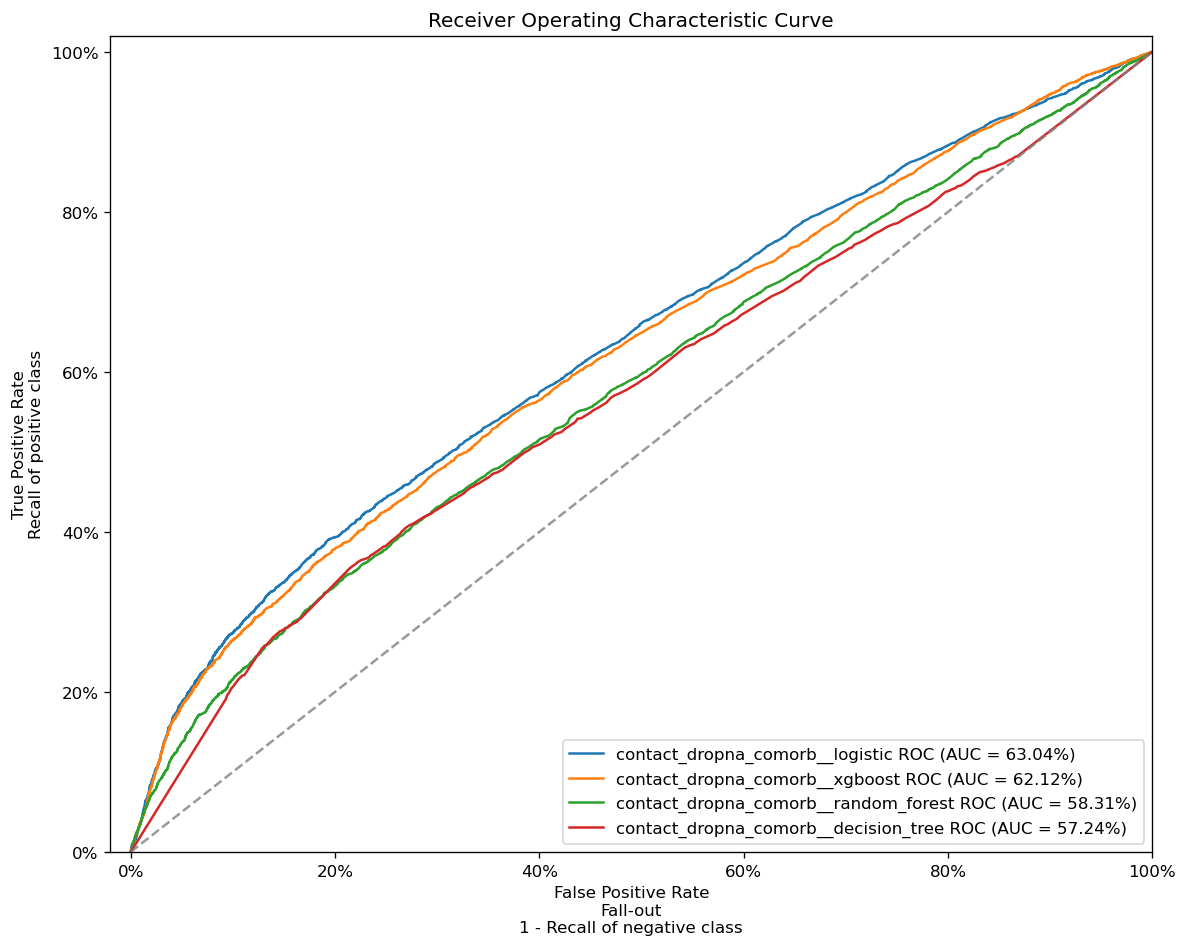

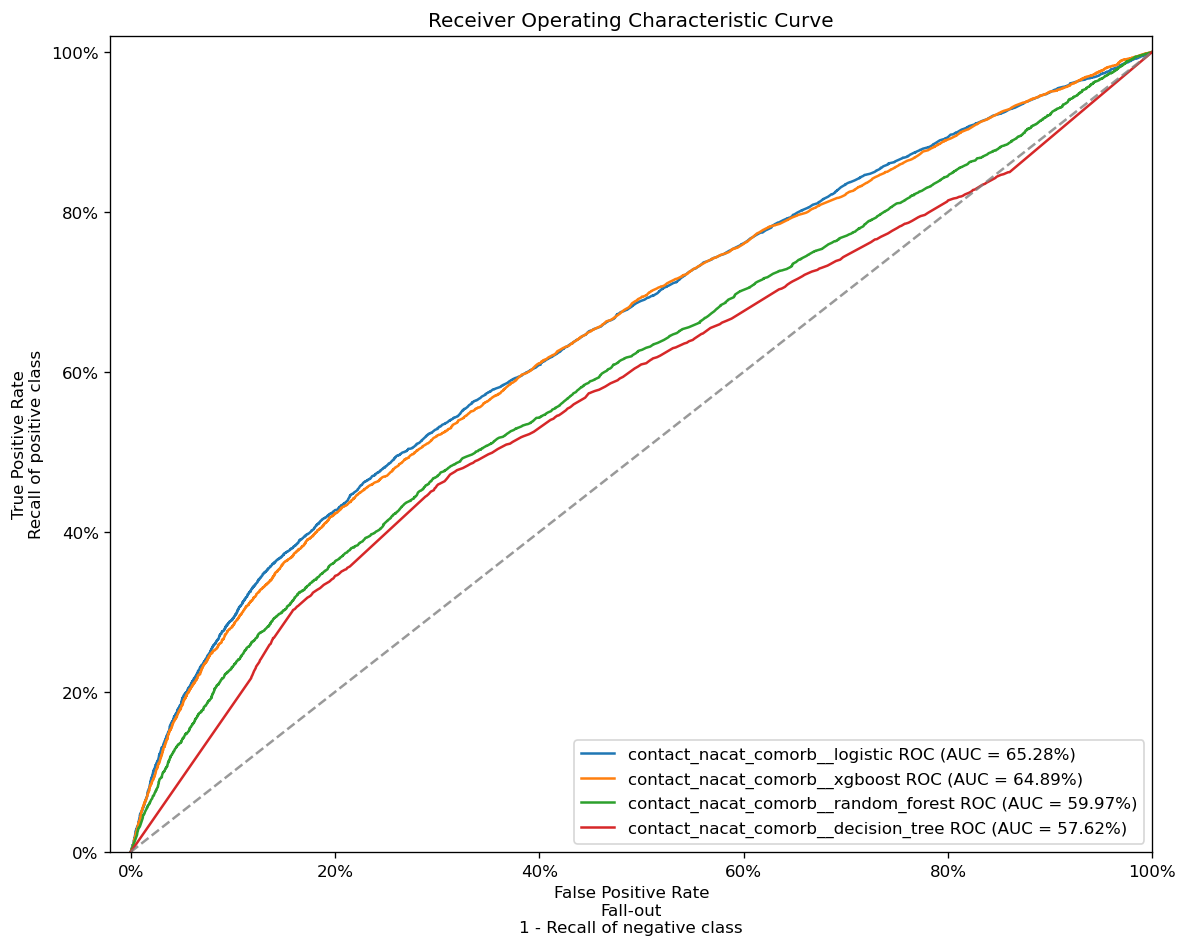

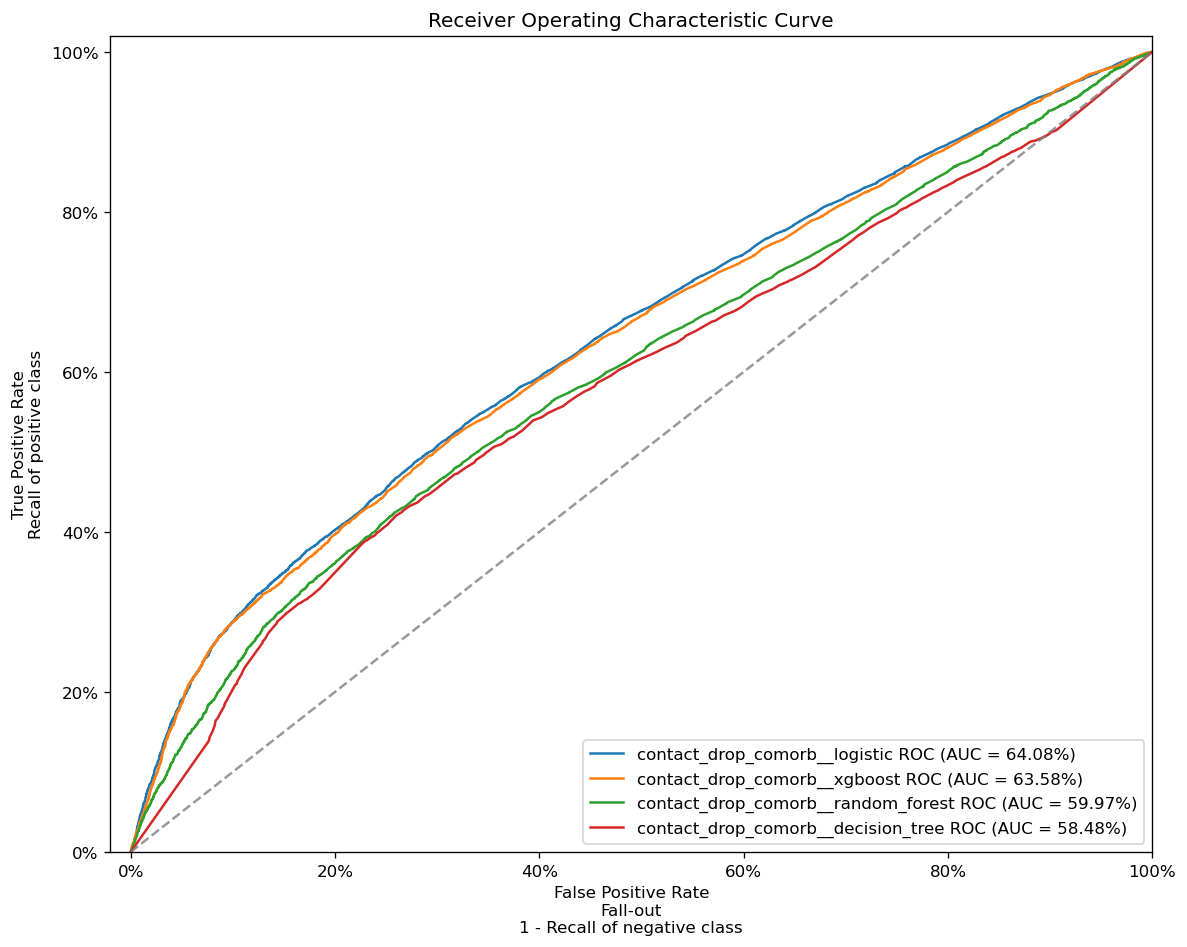

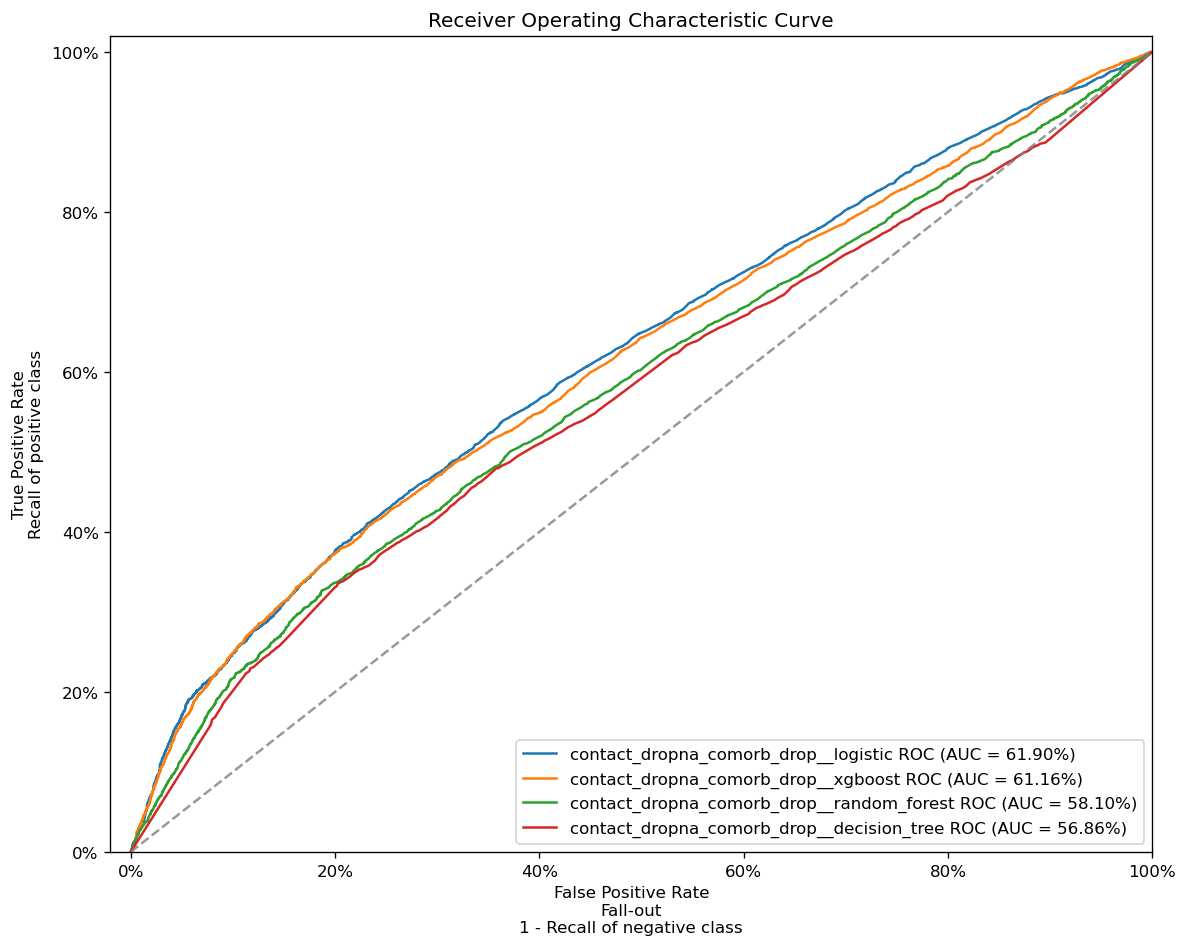

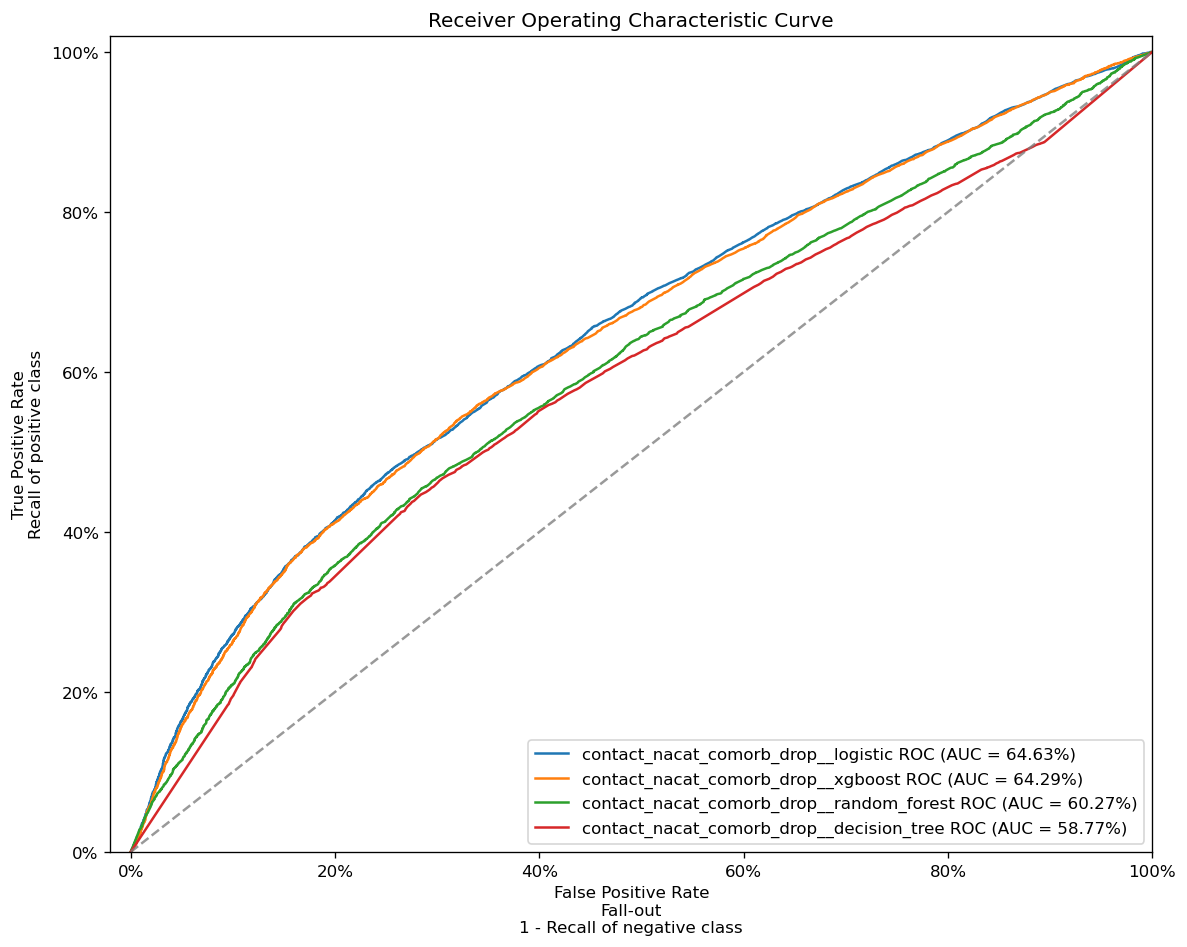

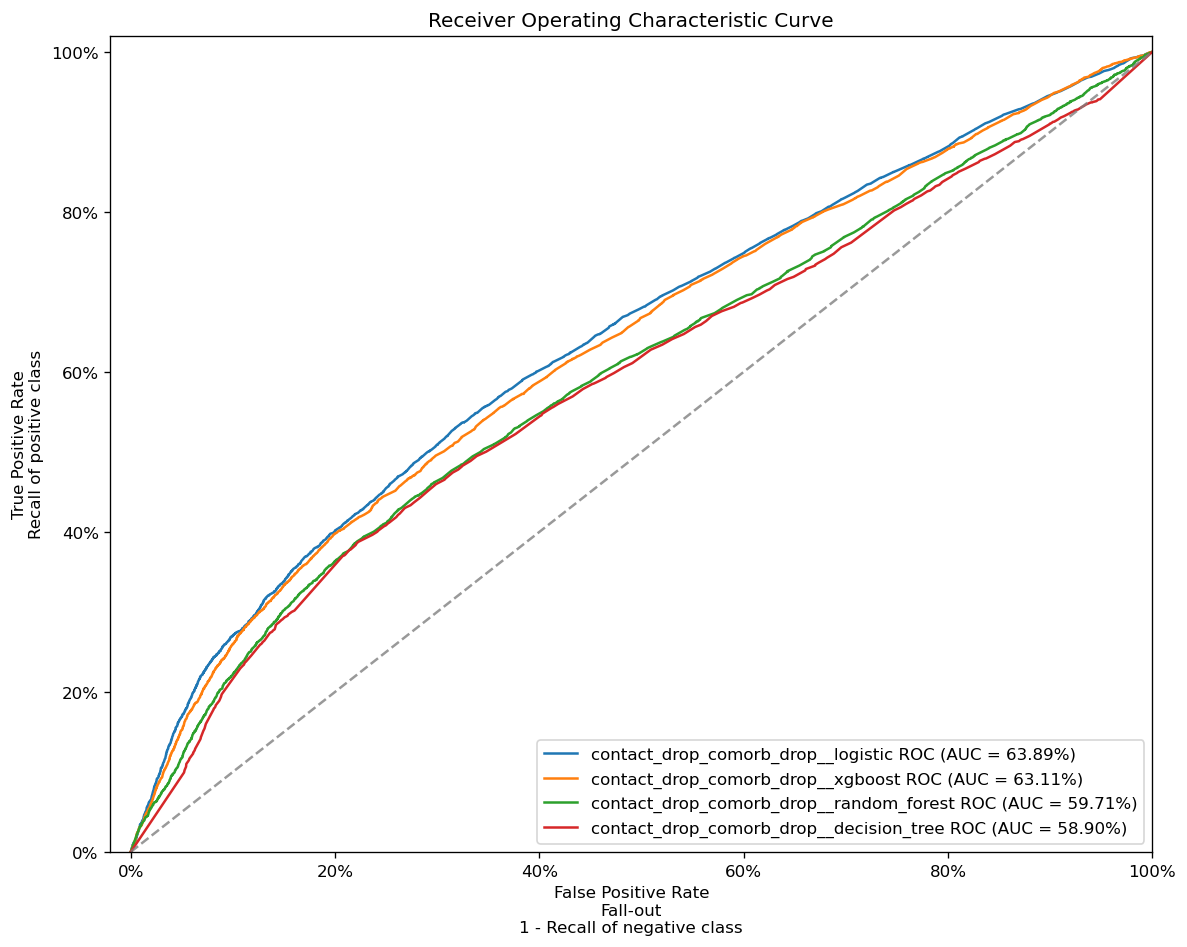

In [21]:
from pprint import pprint

model_ranks = {}
for preproc_name, tts in tts_tuples.items():

    clfs_preproc = { full_name: clf for full_name, clf in clfs.items() if full_name.startswith(f'{preproc_name}__') }

    # transformers = { full_name: clf.steps[0][1].transformers for full_name, clf in clfs.items() if full_name.startswith(preproc_name) }
    # print(f'{preproc_name} X_test columns = {tts[1].columns}')
    # pprint(transformers)

    model_ranks[preproc_name] = splt.plot_roc_auc_curve(
        models = clfs_preproc,
        X_test = tts[1], y_test = tts[3],
    )

In [22]:
model_rank_all = (
    pd.concat(
        [ model_rank for model_rank in model_ranks.values() ]
    )
    .sort_values(by = 'brier', ascending = True)
)

preproc_model_idx = model_rank_all.index.str.split('__', expand = True)

preproc_model_idx.names = ('preproc', 'model_name')
model_rank_all.index = preproc_model_idx

model_rank_all

,,model,auroc,brier,logloss,f1,precision,recall,accuracy
preproc,model_name,,,,,,,,
contact_dropna_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.630388,0.225069,0.642106,0.37975,0.659141,0.266702,0.648097
contact_nacat_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.652783,0.226851,0.645626,0.482394,0.65395,0.382143,0.63765
contact_dropna_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.619011,0.228011,0.648316,0.361415,0.624176,0.254344,0.636956
contact_dropna_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.621227,0.228091,0.650409,0.394084,0.620477,0.288734,0.641369
contact_drop_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.640846,0.228802,0.649618,0.456917,0.645068,0.35374,0.62845
contact_nacat_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.648946,0.228863,0.651561,0.489699,0.636051,0.398099,0.6334
contact_nacat_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.646262,0.229184,0.650634,0.471254,0.64152,0.372411,0.63075
contact_drop_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.638918,0.230223,0.652703,0.444543,0.640545,0.340387,0.62415
contact_drop_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.635789,0.230545,0.654558,0.460988,0.627313,0.364377,0.6235


In [23]:
model_rank_all.sort_values(by = 'auroc', ascending = False)

model  \
preproc                    model_name                                                         
contact_nacat_comorb       logistic       (ColumnTransformer(transformers=[('numericas',...   
                           xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb_drop  logistic       (ColumnTransformer(transformers=[('numericas',...   
                           xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        logistic       (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb_drop   logistic       (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb_drop   xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb      logistic       (ColumnTransformer(transformers=[('numericas',...   
                           xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb_drop logistic       (ColumnTransformer(transformers=[('numericas',...   
                           xgboost        (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb_drop  random_forest  (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        random_forest  (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb       random_forest  (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb_drop   random_forest  (ColumnTransformer(transformers=[('numericas',...   
                           decision_tree  (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb_drop  decision_tree  (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        decision_tree  (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb      random_forest  (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb_drop random_forest  (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb       decision_tree  (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb      decision_tree  (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb_drop decision_tree  (ColumnTransformer(transformers=[('numericas',...   

                                             auroc     brier   logloss  \
preproc                    model_name                                    
contact_nacat_comorb       logistic       0.652783  0.226851  0.645626   
                           xgboost        0.648946  0.228863  0.651561   
contact_nacat_comorb_drop  logistic       0.646262  0.229184  0.650634   
                           xgboost        0.642871  0.231475  0.658434   
contact_drop_comorb        logistic       0.640846  0.228802  0.649618   
contact_drop_comorb_drop   logistic       0.638918  0.230223  0.652703   
contact_drop_comorb        xgboost        0.635789  0.230545  0.654558   
contact_drop_comorb_drop   xgboost        0.631091  0.233022  0.660027   
contact_dropna_comorb      logistic       0.630388  0.225069  0.642106   
                           xgboost        0.621227  0.228091  0.650409   
contact_dropna_comorb_drop logistic       0.619011  0.228011  0.648316   
                           xgboost        0.611635  0.230895  0.656561   
contact_nacat_comorb_drop  random_forest  0.602672  0.258564  0.988511   
contact_drop_comorb        random_forest  0.599707  0.251596  0.903456   
contact_nacat_comorb       random_forest  0.599692  0.257961  0.944304   
contact_drop_comorb_drop   random_forest  0.597145  0.250447  0.872866   
                           decision_tree  0.589042  0.263938   2.49464   
contact_nacat_comorb_drop  decision_tree  0.587749  0.283994  4.067456   
contact_drop_comorb        decision_tree   0.58479  0.277026  3.502622   
contact_dropna_comorb      random_forest   0.58314   0.25474 

### Em resumo...

No fim, optamos pelos modelos de **regressão logística e XGBoost** e pela estratégia de pré-processamento de
* **codificar os `NaN` como uma categoria a parte,** visto que o desempenho deste no AUROC foi superior e a diferença da performance na calibragem de probabilidades foi muito similar; e
* **não eliminar da análise as comorbidades com baixa prevalência (menor que 5%) da classe positiva.**

In [25]:
model_export = {}

# codificar o nan como uma categoria separada e não dropar as comorbidades
preproc = 'contact_nacat_comorb'
models = ['logistic', 'xgboost']

# modelos: pipeline com o standardscaler e o onehotencoder
model_export['modelo'] = {
    model_name: model_rank_all.at[(preproc, model_name), 'model']
    for model_name in models
}

# train_test_split: tupla com 2 dataframes (X_train, X_test) e 2 series (y_train e y_test)
model_export['train_test_split'] = tts_tuples[preproc]

# base: df covid já transformado
model_export['base'] = bases[preproc]

## Análise de importância de *features*

Agora que selecionamos os modelos para otimização, vamos inspecionar quais variáveis afetam mais o resultado segundo os modelos.

Para tal utilizaremos uma técnica baseada em valores de Shapley para explicação de modelos *black-box* de aprendizado de máquina. Uma introdução a essa técnica pode ser encontrada [aqui](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [26]:
import shap

X_train, X_test, y_train, y_test = model_export['train_test_split']

downsample = 300

Xtrainpeq = shap.utils.sample(X_train, downsample).reset_index(drop = True)
Xpeq = shap.utils.sample(X_test, downsample).reset_index(drop = True)

### Cálculo

Primeiramente, vamos calcular os valores de Shapley para cada modelo, baseado nas probabilidades do mesmo.

O [cálculo desses valores](https://christophm.github.io/interpretable-ml-book/shap.html#definition) é extremamente custoso computacionalmente. Por isso, vamos usar uma amostra pequena da base.

In [27]:
modelos = model_export['modelo'].copy()
explainers = {}
shaps = {}

for nome_modelo, modelo in modelos.items():

    print(f"Calculando valores de Shapley para o modelo '{nome_modelo}'... ")

    explainer = shap.Explainer(
        model = lambda X: modelo.predict_proba(X)[:, 1], 
        masker = Xtrainpeq, 
        #link = shap.links.logit
    )
    
    shap_values = explainer(Xpeq)

    explainers[nome_modelo] = explainer
    shaps[nome_modelo] = shap_values

Calculando valores de Shapley para o modelo 'logistic'... 


Permutation explainer: 301it [00:47,  5.52it/s]                         


Calculando valores de Shapley para o modelo 'xgboost'... 


Permutation explainer: 301it [01:28,  3.07it/s]                         


### Análise

Em seguida, vamos ver quais fatores são mais importantes:

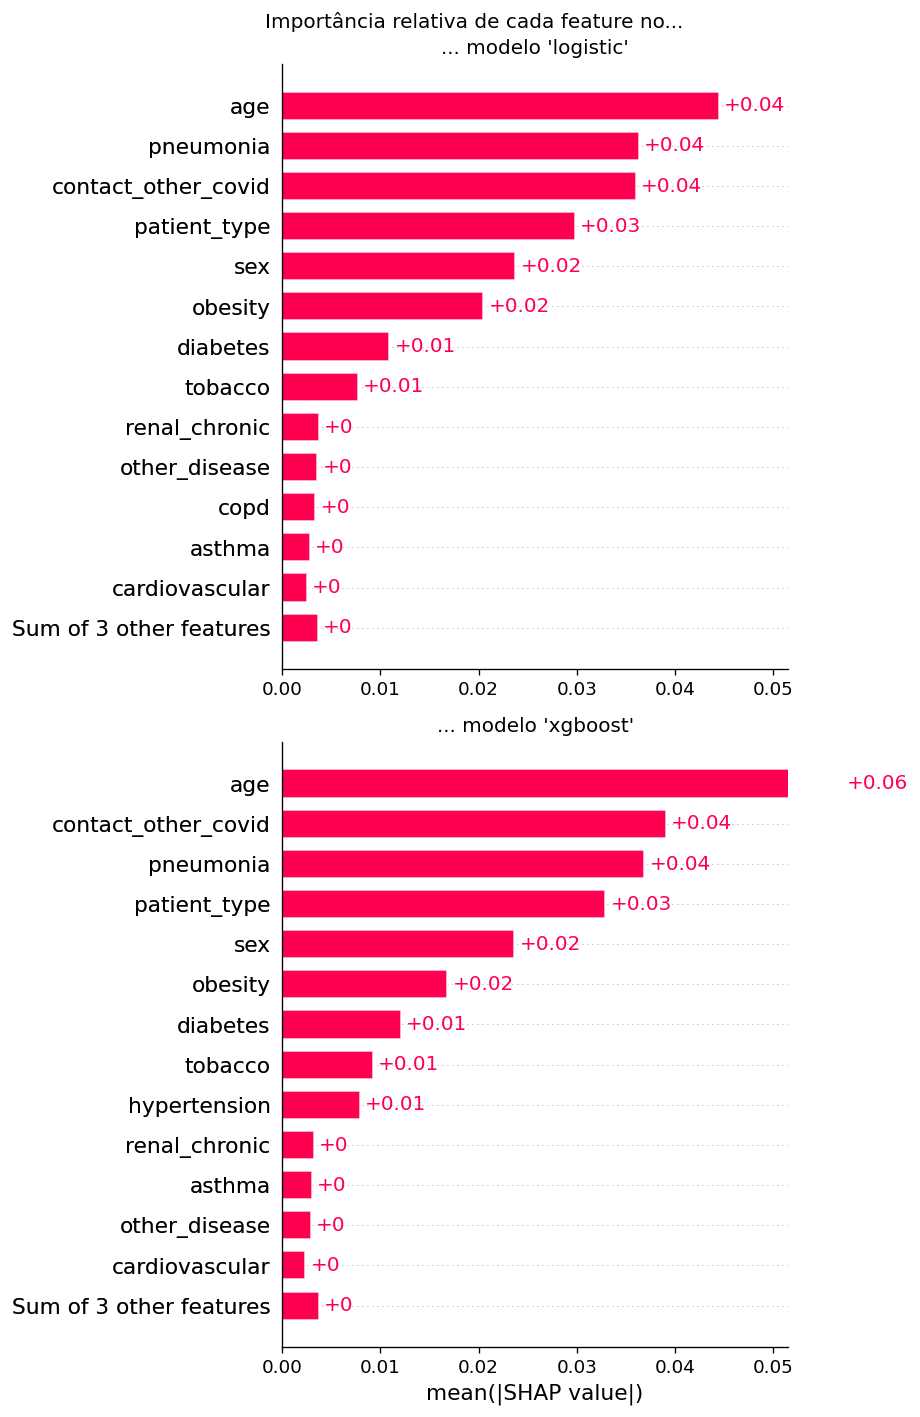

In [28]:
fig, axs = plt.subplots(nrows = len(shaps.keys()), sharex = True)

sex_cohort = [ 'Homens' if shap_values[i, 'sex'] == 0 else 'Mulheres' for i in range(shap_values.shape[0]) ]

for i, (nome_modelo, shap_values) in enumerate(shaps.items()):

    ax = axs[i]
    fig.sca(ax)

    shap.plots.bar(shap_values.cohorts(sex_cohort), max_display = 14, show = False)

    ax.set_title(f"... modelo '{nome_modelo}'")
    
    if i < len(shaps.keys()) - 1:
        ax.set_xlabel('') 

fig.suptitle('Importância relativa de cada feature no...')
fig.set_figheight(12)
plt.tight_layout()
plt.show()

Vemos que, nos dois modelos, os 6 fatores mais importantes na previsão de exames de COVID são os mesmos: `age`, `contact_other_covid`, `pneumonia`, `obesity`, `patient_type` (se o paciente foi liberado para casa ou internado) e `sex`. No dois modelos, o fator idade foi o mais relevante.

Vemos também que os campos com baixa prevalência em geral são os que menos influenciam no modelo.

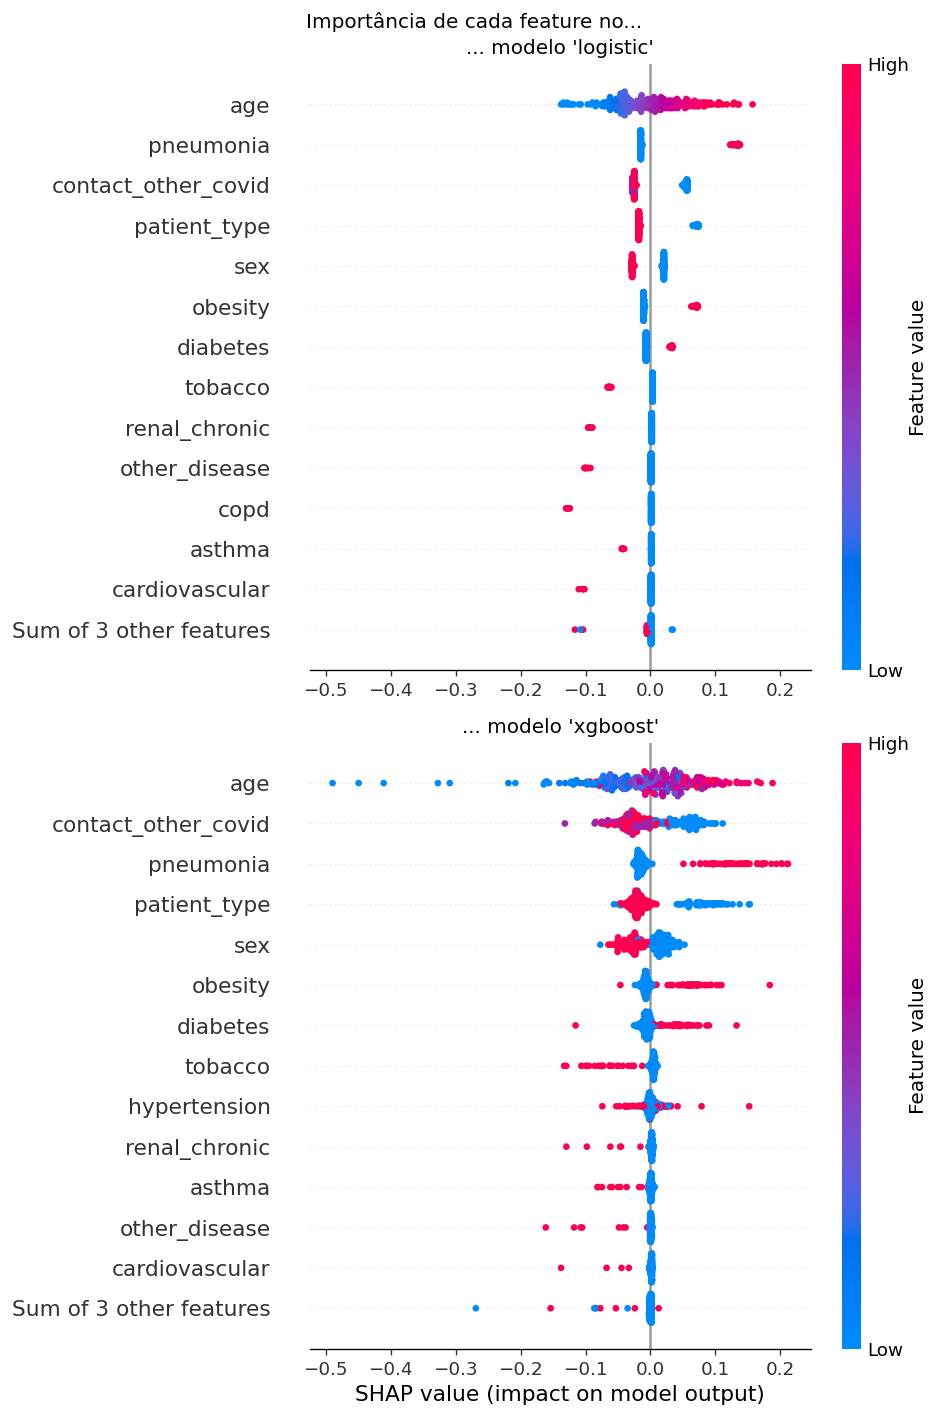

In [29]:
fig, axs = plt.subplots(nrows = len(shaps.keys()), sharex = True)

for i, (nome_modelo, shap_values) in enumerate(shaps.items()):

    ax = axs[i]
    fig.sca(ax)

    shap.plots.beeswarm(shap_values, max_display = 14, show = False)

    ax.set_title(f"... modelo '{nome_modelo}'")
    
    if i < len(shaps.keys()) - 1:
        ax.set_xlabel('') 

fig.suptitle('Importância de cada feature no...')
fig.set_figheight(12)

plt.tight_layout()
plt.show()

#shap.summary_plot(shap_values, plot_type = 'violin')

Vemos que o modelo de regressão logística captura pouco das interações entre as características dos pacientes:
* a influência dos fatores está dividida claramente conforme seus valores; e
* dentre os casos em que um *feature* influi bastante no modelo, essa influência é sempre a mesma.

Já o modelo *XGBoost* captura as interações muito bem: há no gráfico de *swarm* muitos valores intermediários com influência, evidenciando que há interações relevantes no modelo. A quantificação da influência (representada pelos valores de Shapley) está mais distribuída entre os casos em que uma *feature* tem influência no modelo.

Confirmando o que vimos no gráfico de barra, alguns dos fatores que menos influenciam a resposta do modelo (`renal_chronic`, `asthma`, `inmsupr`, `copd`, `cardiovascular`) nos dois modelos são campos com pouca prevalência da classe positiva. Não é surpreendente que tenham pouca influência.

Nos dois modelos, o fator que mais teve influência na previsão de testes de COVID foi a idade. Pessoas mais idosas tendem o modelo para prever teste positivo mais frequentemente. No modelo *XGBoost*, há bastante interação da idade com outros fatores.

Alguns fatores que tendem o modelo fortemente a prever testes positivos:
* Pneumonia;
* Internação;
* Paciente do sexo masculino;
* Obesidade ou diabetes; e
* Paciente não-fumante!

A previsão do resultado do teste para COVID tende para o lado positivo em pacientes cujo contato com outras pessoas que tenham COVID não tenha sido registrado.

Surpreendentemente, pacientes fumantes ou com problemas cardiovasculares tendem o modelo a prever testes negativos, mas essa tendência não é muito forte.

Um caso digo de nota em que o modelo de regressão logística não captura muito bem a interrelação entre os vários fatores é no gráfico que plota a relação entre os valores de idade e seus respectivos valores de Shapley:

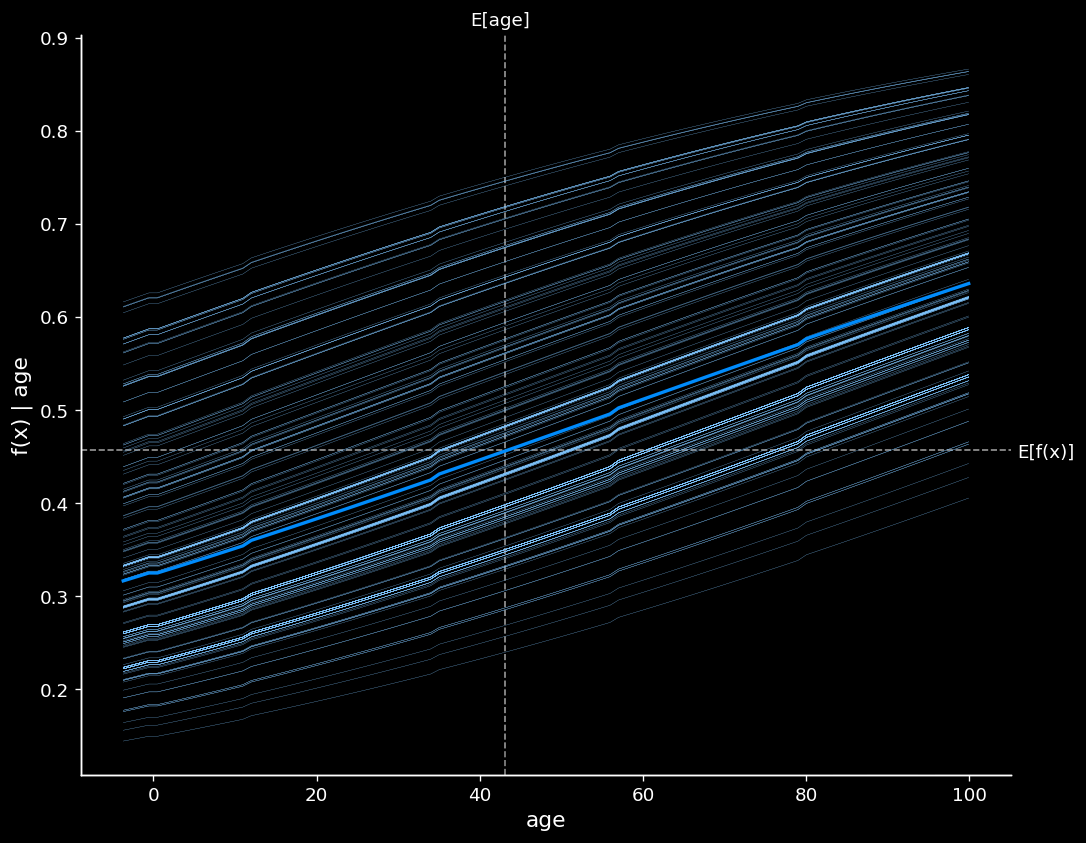

In [30]:
with plt.style.context('dark_background'):
    shap.partial_dependence_plot(
        'age',
        lambda X: modelos['logistic'].predict_proba(X)[:, 1], Xpeq,
        model_expected_value = True,
        feature_expected_value = True,
        ice = True,
        #shap_values = shap_values[100:101, :]
    )

No gráfico acima, notamos que a relação é linear com correlação quase 100% perfeita. Isso indica que o estimador de influência não considera a interrelação entre a idade e outros fatores na consideração da importância da idade na resposta do modelo.

Notamos ainda que, mesmo no modelo de regressão logística, há correlações importante entre os *features*:

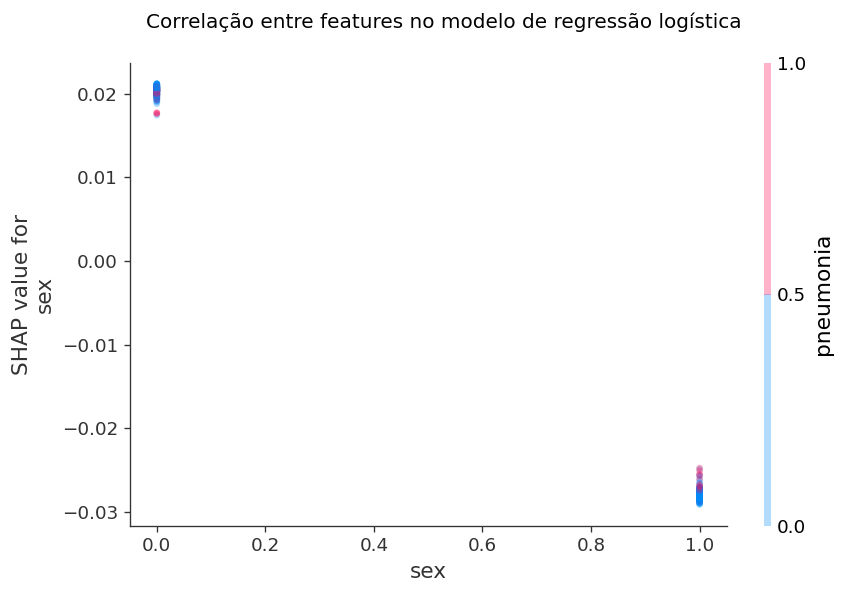

In [31]:
shap_values = shaps['logistic']

shap.dependence_plot(
    'sex', 
    shap_values.values,
    Xpeq,
    interaction_index = 'pneumonia',
    show = False,
    alpha = 0.3
)

fig = plt.gcf()

fig.suptitle('Correlação entre features no modelo de regressão logística')
#fig.set_figheight(12)

plt.tight_layout()
plt.show()



Nesse exemplo, mostramos que homens (`sex == 0`) tendem a apresentar pneumonia mais frequentemente que mulheres.

Um detalhe interessante é que, dos campos que apontamos previamente que havia baixa prevalência da classe positiva, todas as ocorrências da classe positiva correspondem a uma grande influência na resposta do modelo (lembrando que o maior valor absoluto do coeficiente SHAP no conjunto de dados é ~ 0.4):

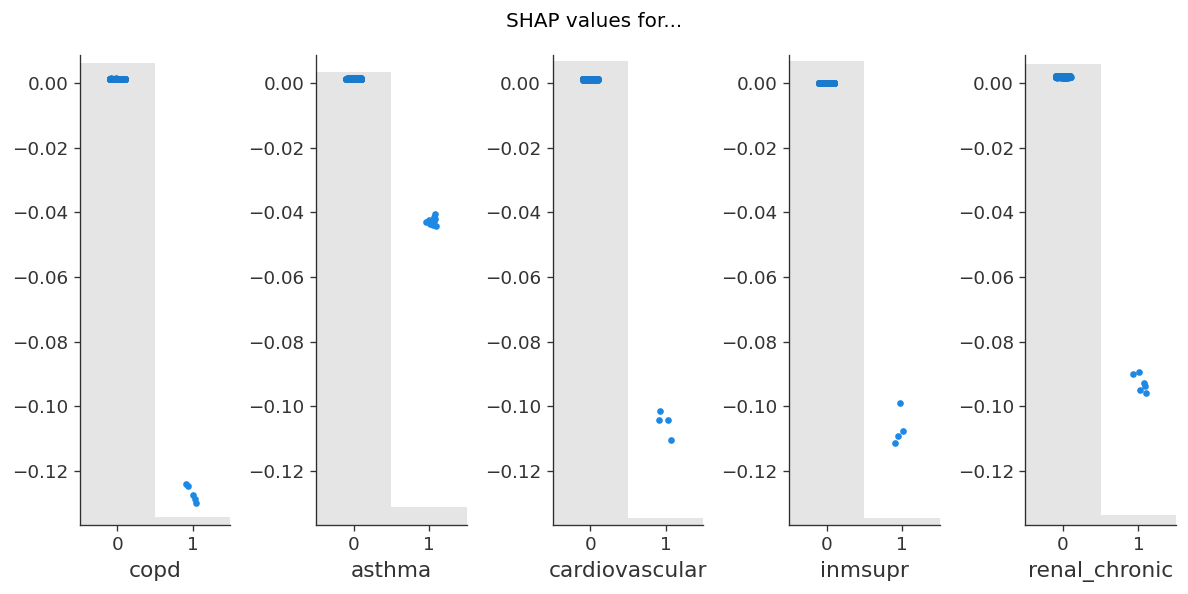

In [32]:
features = [ 'copd', 'asthma', 'cardiovascular', 'inmsupr', 'renal_chronic' ]

fig, axs = plt.subplots(ncols = len(features), sharey = True, figsize = (10,5))

for i, feature in enumerate(features):
    ax = axs[i]

    shap.plots.scatter(
        shap_values = shap_values[:, feature],
        ax = ax, show = False
    )

    ax.set_ylabel('')
    #ax.set_title(f"'{feature}'")

fig.suptitle('SHAP values for...')

plt.tight_layout()
plt.show()

Em outras palavras: há poucos pacientes que tem essas comorbidades, o que se reflete na pouca influência da *feature* no resultado do modelo em geral. No entanto, quando o paciente tem uma delas, o modelo é bastante influenciado por essa comorbidade.

A surpresa está no fato de as comorbidades influenciarem o modelo no sentido de uma previsão de teste negativo! Ou seja, quando o paciente tem a comorbidade, tende a ter uma previsão de resultado negativo para o teste de COVID:

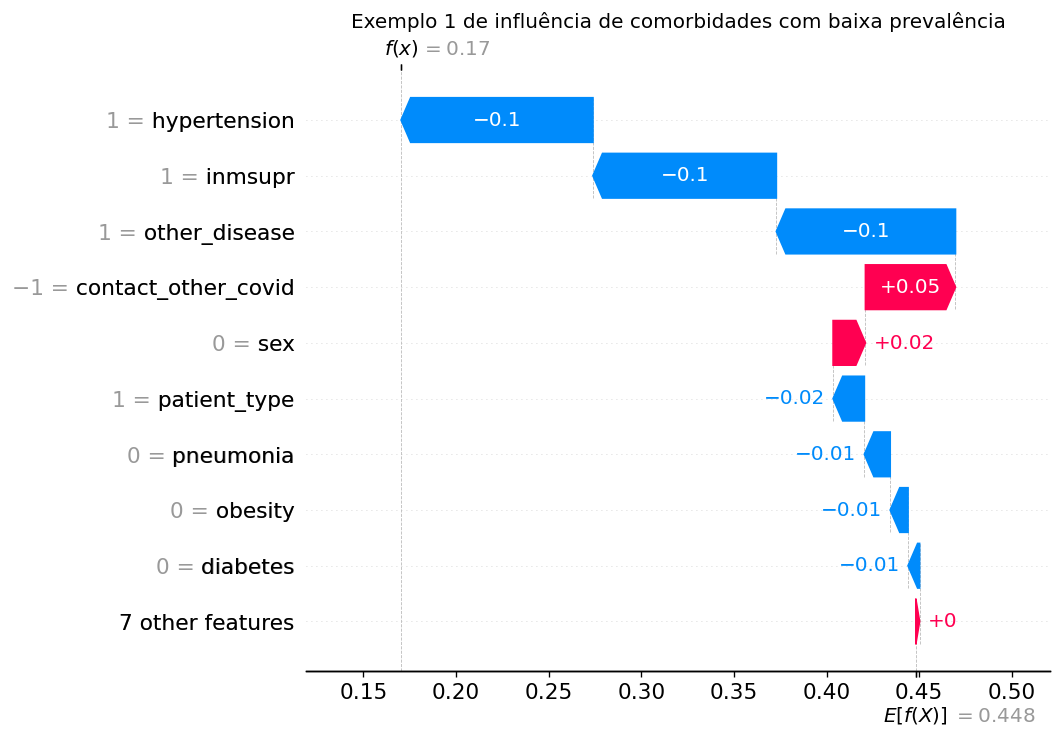

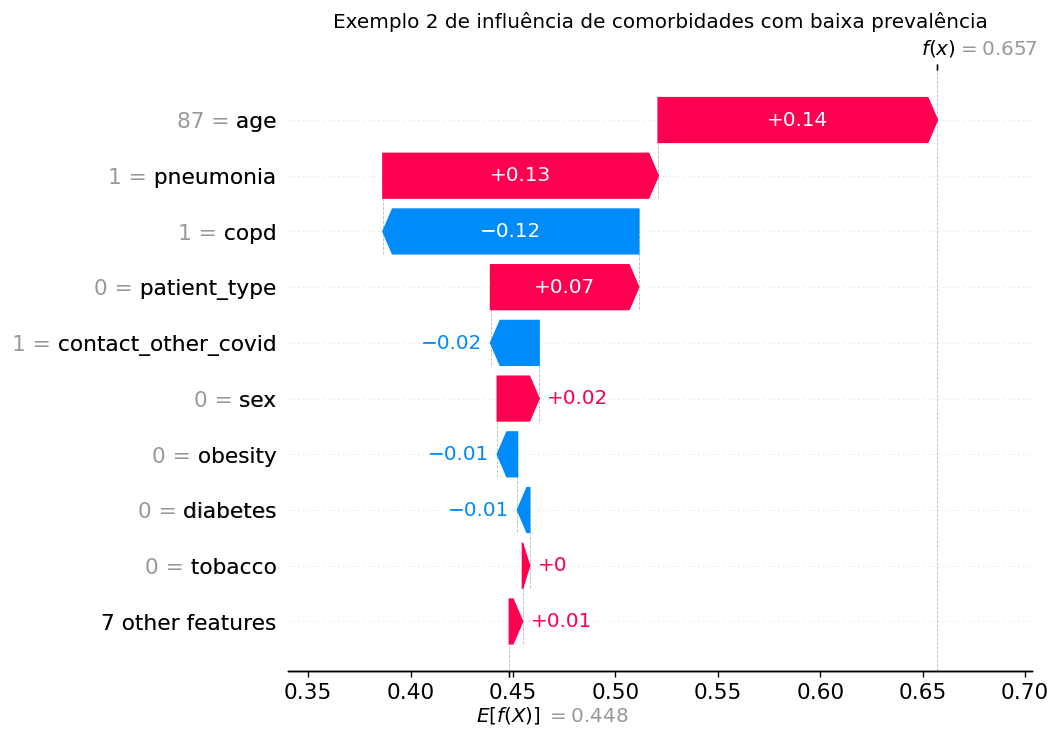

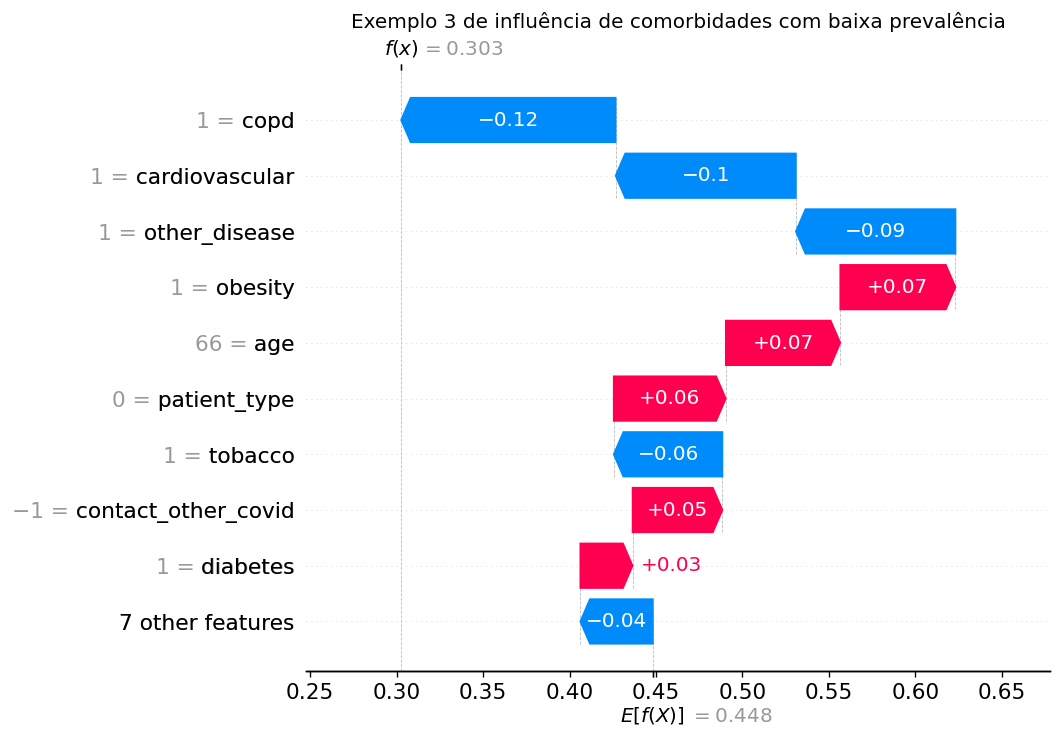

In [33]:
tem_comorb_rara = (
    (Xpeq.copd == 1) |
    (Xpeq.asthma == 1) |
    (Xpeq.cardiovascular == 1) |
    (Xpeq.inmsupr == 1) |
    (Xpeq.renal_chronic == 1)
)

n_exs = 3

exs_comorb_rara = np.random.choice(Xpeq[tem_comorb_rara].index, n_exs)

for i, ex_idx in enumerate(exs_comorb_rara):

    fig = plt.figure()

    shap.plots.waterfall(
        shap_values[ex_idx],
        show = False,
    )

    ax = plt.gca()
    ax.set_title(f'Exemplo {i+1} de influência de comorbidades com baixa prevalência')

    if i < n_exs:
        ax.set_xlabel('')
    
    plt.show()

Cada um dos gráficos anteriores representa um paciente. O estimador de influência parte da média dos valores Shapley da base reduzida e calcula o quanto cada fator o moveu. Após somar todas as influências, o estimador de influência chega na estimativa de influência final de cada exemplo de paciente.

Há alguns potenciais motivos por trás desse resultado surpreendente:

* como as comorbidades são raras, sempre há a possibilidade de este ser um resultado espúrio, que não se confirmaria ao calcular os valores SHAP para toda a base;
* as comorbidades `cardiovascular`, `copd`, `renal_chonic` são positivamente correlacionadas com a idade que é o fator mais influente no resultado do modelo. A idade então engloba quase todo o poder explicativo que estes campos poderiam ter, restanto a eles um poder explicativo "negativo":

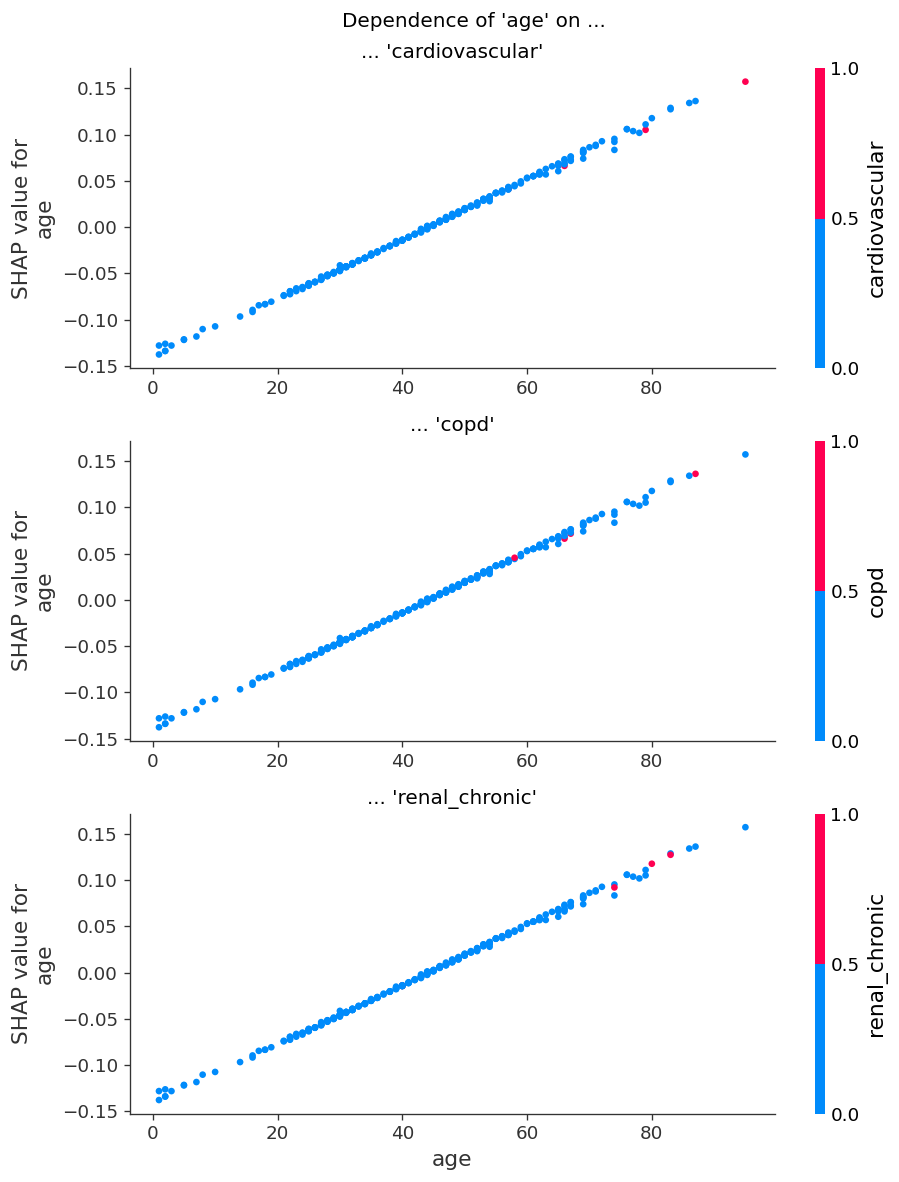

In [34]:
correlated_age = [ 'cardiovascular', 'copd', 'renal_chronic' ]

fig, axs = plt.subplots(nrows = len(correlated_age), sharex = True, figsize = (8, 10))

for i, feature in enumerate(correlated_age):
    ax = axs[i]

    shap.dependence_plot(
        'age', 
        shap_values.values,
        Xpeq,
        interaction_index = feature,
        ax = ax,
        show = False
    )
    
    if i < len(correlated_age)-1:
        ax.set_xlabel('')

    ax.set_title(f"... '{feature}'")

fig.suptitle("Dependence of 'age' on ...")

plt.tight_layout()
plt.show()



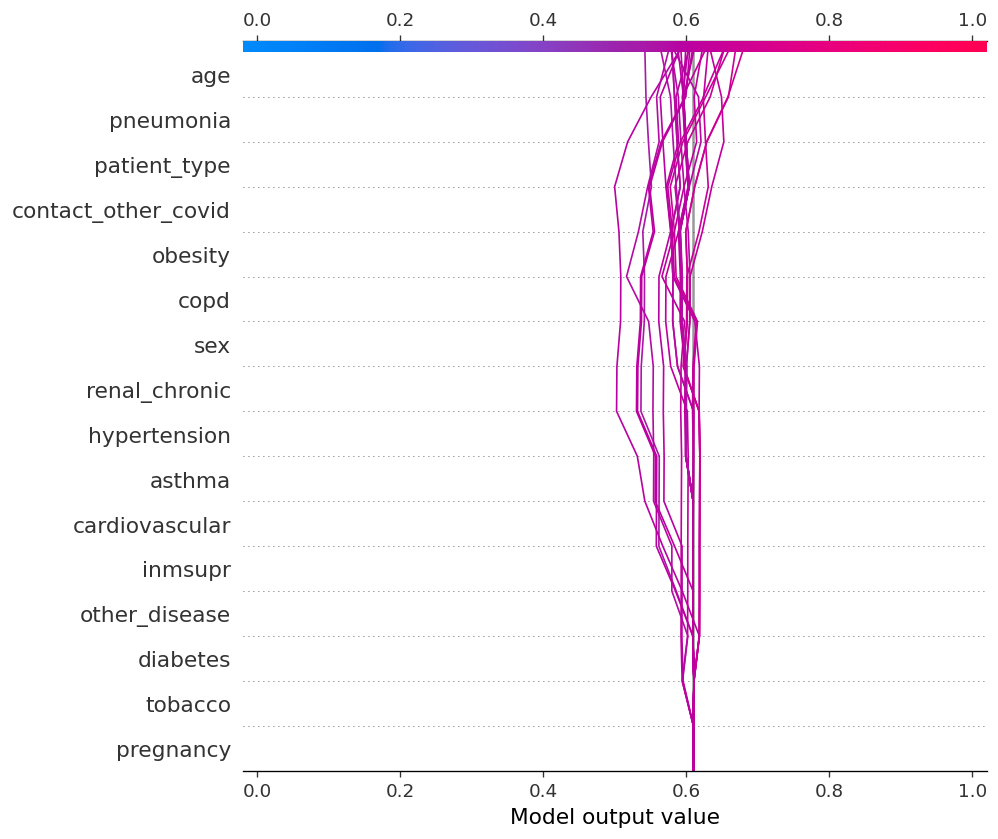

In [35]:
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[tem_comorb_rara], 
    feature_names = list(Xpeq.columns), 
    link = 'logit',
)

In [36]:
shap.initjs()

shap.force_plot(
    base_value = shap_values.base_values[0], 
    shap_values = shap_values.values[tem_comorb_rara], 
    feature_names = Xpeq.columns
)

### Conclusões

A análise de importância dos features mostrou que **a idade e o status de contato com outras pessoas comprovadamente com COVID são os fatores mais importantes** para a predição do resultado do teste de COVID.

Outros fatores importantes são 
* se o paciente apresenta pneumonia;
* se ele é homem ou mulher: homens tem maior probabilidade de receber um teste positivo para COVID;
* se ele foi liberado para casa ou se foi internado; e
* se o paciente é obeso.

Concluímos também que o modelo XGBoost é o que mais captura as interrelações entre os *features*.

## Conclusões finais de modelagem

### Modelo / Estimador

Independentemente da estratégia de pré-processamento, **os modelos de regressão logística e *XGBoost* performaram melhor que os outros**.

O AUROC dos dois está acima de 62%, enquanto que os outros estão abaixo de 60%. Separando por cada estratégia de pré-processamento, a média da diferença entre o AUROC do modelo logístico/XGBoost e dos outros é de ~3-4%.

Além disso, a calibragem de probabilidades dos dois modelos está significativamente melhor que os outros. O *Brier score* dos dois está abaixo de 0.23, enquanto que o dos outros está acima de 0.25 (menor é melhor). A *logloss* está abaixo de 0.66, enquanto que a dos outros está acima de 0.91.

O modelo XGBoost captura melhor as correlações entre os *features*, mas no desempenho no AUROC e nas métricas de aderência de probabilidade o modelo de regressão logística performa ligeiramente melhor.

Por esses motivos, **estes dois modelos (regressão logística e XGBoost) seguem para tentativas de otimização**.

### Estratégia de pré-processamento

A respeito da escolha da estratégia de pré-processamento, ainda não temos um vencedor claro.


In [37]:
idx = pd.IndexSlice
model_rank_all.loc[idx[:, ['logistic', 'xgboost']], :].sort_values(by = 'auroc', ascending = False)

model  \
preproc                    model_name                                                      
contact_nacat_comorb       logistic    (ColumnTransformer(transformers=[('numericas',...   
                           xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb_drop  logistic    (ColumnTransformer(transformers=[('numericas',...   
                           xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        logistic    (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb_drop   logistic    (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb        xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_drop_comorb_drop   xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb      logistic    (ColumnTransformer(transformers=[('numericas',...   
                           xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_dropna_comorb_drop logistic    (ColumnTransformer(transformers=[('numericas',...   
                           xgboost     (ColumnTransformer(transformers=[('numericas',...   

                                          auroc     brier   logloss        f1  \
preproc                    model_name                                           
contact_nacat_comorb       logistic    0.652783  0.226851  0.645626  0.482394   
                           xgboost     0.648946  0.228863  0.651561  0.489699   
contact_nacat_comorb_drop  logistic    0.646262  0.229184  0.650634  0.471254   
                           xgboost     0.642871  0.231475  0.658434  0.493506   
contact_drop_comorb        logistic    0.640846  0.228802  0.649618  0.456917   
contact_drop_comorb_drop   logistic    0.638918  0.230223  0.652703  0.444543   
contact_drop_comorb        xgboost     0.635789  0.230545  0.654558  0.460988   
contact_drop_comorb_drop   xgboost     0.631091  0.233022  0.660027  0.452226   
contact_dropna_comorb      logistic    0.630388  0.225069  0.642106   0.37975   
                           xgboost     0.621227  0.228091  0.650409  0.394084   
contact_dropna_comorb_drop logistic    0.619011  0.228011  0.648316  0.361415   
                           xgboost     0.611635  0.230895  0.656561  0.384691   

                                      precision    recall  accuracy  
preproc                    model_name                                
contact_nacat_comorb       logistic     0.65395  0.382143   0.63765  
                           xgboost     0.636051  0.398099    0.6334  
contact_nacat_comorb_drop  logistic     0.64152  0.372411   0.63075  
                           xgboost     0.623166   0.40851    0.6295  
contact_drop_comorb        logistic    0.645068   0.35374   0.62845  
contact_drop_comorb_drop   logistic    0.640545  0.340387   0.62415  
contact_drop_comorb        xgboost     0.627313  0.364377    0.6235  
contact_drop_comorb_drop   xgboost     0.629211  0.352948    0.6222  
contact_dropna_comorb      logistic    0.659141  0.266702  0.648097  
                           xgboost     0.620477  0.288734  0.641369  
contact_dropna_comorb_drop logistic    0.624176  0.254344  0.636956  
                           xgboost     0.606166  0.281748  0.635943

#### Tratamento do campo `contact_other_covid`

O maior AUROC é o modelo de regressão logística com a estratégia de pré-processamento `contact_nacat` (codificar os `NaN` como uma categoria separada), mas a calibragem de probabilidades está ligeiramente melhor na estratégia `contact_dropna` (eliminar os registros em que `contact_other_covid` está faltando).

Apesar de a estratégia `contact_drop` (eliminar o campo `contact_other_covid` da análise) estar em "4° lugar" em termos de calibragem de análise, aparece como ótima alternativa em termos do AUROC.

Optamos no fim por **codificar os `NaN` como uma categoria a parte,** visto que o desempenho deste no AUROC foi superior e a diferença da performance na calibragem de probabilidades foi muito similar;

In [38]:
model_rank_all.loc[
    idx[
        ['contact_nacat_comorb', 'contact_nacat_comorb_drop'], 
        ['logistic', 'xgboost']
], :].sort_values(by = 'auroc', ascending = False)

model  \
preproc                   model_name                                                      
contact_nacat_comorb      logistic    (ColumnTransformer(transformers=[('numericas',...   
                          xgboost     (ColumnTransformer(transformers=[('numericas',...   
contact_nacat_comorb_drop logistic    (ColumnTransformer(transformers=[('numericas',...   
                          xgboost     (ColumnTransformer(transformers=[('numericas',...   

                                         auroc     brier   logloss        f1  \
preproc                   model_name                                           
contact_nacat_comorb      logistic    0.652783  0.226851  0.645626  0.482394   
                          xgboost     0.648946  0.228863  0.651561  0.489699   
contact_nacat_comorb_drop logistic    0.646262  0.229184  0.650634  0.471254   
                          xgboost     0.642871  0.231475  0.658434  0.493506   

                                     precision    recall accuracy  
preproc                   model_name                               
contact_nacat_comorb      logistic     0.65395  0.382143  0.63765  
                          xgboost     0.636051  0.398099   0.6334  
contact_nacat_comorb_drop logistic     0.64152  0.372411  0.63075  
                          xgboost     0.623166   0.40851   0.6295

#### Eliminação de comorbidades

Sobre a opção por eliminar as comorbidades com baixa prevalência da classe positiva, não há muita diferença. 

No interesse da consistência, vamos utilizar o AUROC para selecionar. **Optamos portanto por não eliminar essas comorbidades da análise.**

### Em resumo...

No fim, optamos pelos modelos de **regressão logística e XGBoost** e pela estratégia de pré-processamento de
* **codificar os `NaN` como uma categoria a parte,** visto que o desempenho deste no AUROC foi superior e a diferença da performance na calibragem de probabilidades foi muito similar; e
* **não eliminar da análise as comorbidades com baixa prevalência (menor que 5%) da classe positiva.**

## Exportação dos modelos para otimização

Por fim, vamos exportar os dados para otimização.

In [39]:
# salvar via pickle

# with open(r'../models/modelo_default.model', 'wb') as modelfile:
#     pickler = pickle.Pickler(file = modelfile)
#     pickler.dump(model_export)